In [1]:
from matplotlib import pyplot
import numpy
import pandas
import ROOT

ModuleNotFoundError: No module named 'ROOT'

In [2]:
### UTILS
def round_to_nearest_5(n) -> int:
    r = round(n, -1)
    return r if r > n  else r + 5

def get_y_min_max(graph1, graph2) -> tuple[float, float]:
    n_1 = graph1.GetN()
    y_1 = graph1.GetY()
    n_2 = graph2.GetN()
    y_2 = graph2.GetY()

    ymin_1 = ROOT.TMath.MinElement(n_1, y_1)
    ymax_1 = ROOT.TMath.MaxElement(n_1, y_1)

    ymin_2 = ROOT.TMath.MinElement(n_2, y_2)
    ymax_2 = ROOT.TMath.MaxElement(n_2, y_2)
    
    return min(ymin_1, ymin_2), max(ymax_1, ymax_2)

def get_x_min_max(graph1, graph2) -> tuple[float, float]:
    n_1 = graph1.GetN()
    x_1 = graph1.GetX()
    n_2 = graph2.GetN()
    x_2 = graph2.GetX()

    xmin_1 = ROOT.TMath.MinElement(n_1, x_1)
    xmax_1 = ROOT.TMath.MaxElement(n_1, x_1)

    xmin_2 = ROOT.TMath.MinElement(n_2, x_2)
    xmax_2 = ROOT.TMath.MaxElement(n_2, x_2)
    
    return min(xmin_1, xmin_2), max(xmax_1, xmax_2)

def create_mpl_tcolors() -> dict[str, ROOT.TColor]:
    import matplotlib.colors as mcolors
    return {
        name: ROOT.TColor.GetColor(color)
        for name, color in mcolors.TABLEAU_COLORS.items()
        
    }

PYPLOT_TCOLORS = create_mpl_tcolors()

In [3]:
df = pandas.read_csv("data_afterfix.csv")
df

,scheduler,cores,partitions_per_core,time
0,local,1,1,1813.707592
1,local,1,1,1799.218811
2,local,1,1,1775.679246
3,local,1,1,1747.330850
4,local,1,1,1767.631741
...,...,...,...,...
185,dask,32,4,65.233425
186,dask,32,4,63.850999
187,dask,32,4,63.256627
188,dask,32,4,64.165843


In [4]:
dfs = {}
for label, group in df.groupby("scheduler"):
    dfs[label] = group

In [5]:
dfs["local"]

,scheduler,cores,partitions_per_core,time
0,local,1,1,1813.707592
1,local,1,1,1799.218811
2,local,1,1,1775.679246
3,local,1,1,1747.330850
4,local,1,1,1767.631741
5,local,1,1,1753.549301
6,local,1,1,1755.576465
7,local,1,1,1751.652218
8,local,1,1,1767.443690
9,local,1,1,1749.596463


In [6]:
dataset_size = 2244449133 * 50 # bytes
dataset_size_MB = dataset_size / 1e6

In [7]:
seq_time = numpy.mean(dfs["local"].iloc[1:].time)
seq_throughput_MB = dataset_size_MB / seq_time
seq_time, seq_throughput_MB

(1763.0754205650755, 63.65153489238258)

In [8]:
cols = {"cores":[],
        "partitions_per_core":[],
        "first":[],
        "others":[],
        "others_std":[],
        "others_throughput_MB":[],
        "others_throughput_MB_per_core":[],
        "others_speedup":[]}

for label, group in dfs["dask"].groupby(["cores","partitions_per_core"]):
    firstrow = group.iloc[0]
    cores = firstrow.cores
    partitions_per_core = firstrow.partitions_per_core
    cold = firstrow.time
    hot = group.iloc[1:].time.mean()
    stdev = numpy.std(group.iloc[1:].time)
    cols["cores"].append(cores)
    cols["partitions_per_core"].append(partitions_per_core)
    cols["first"].append(cold)
    cols["others"].append(hot)
    cols["others_std"].append(stdev)
    cols["others_throughput_MB"].append(dataset_size_MB/hot)
    cols["others_throughput_MB_per_core"].append(cols["others_throughput_MB"][-1]/cols["cores"][-1])
    cols["others_speedup"].append(cols["others_throughput_MB"][-1]/cols["others_throughput_MB"][0])

df_agg = pandas.DataFrame(cols)
df_agg

,cores,partitions_per_core,first,others,others_std,others_throughput_MB,others_throughput_MB_per_core,others_speedup
0,1,1,1807.388192,1802.427074,13.962643,62.261857,62.261857,1.000000
1,1,2,1824.717119,1833.889887,19.524953,61.193672,61.193672,0.982844
2,1,4,1849.488717,1838.768249,4.932571,61.031322,61.031322,0.980236
3,2,1,923.761953,935.312612,10.868163,119.983902,59.991951,1.927085
4,2,2,933.984884,929.515291,7.947375,120.732233,60.366116,1.939104
5,2,4,925.149026,922.188959,3.748831,121.691390,60.845695,1.954509
6,4,1,472.439025,463.462019,3.530522,242.139489,60.534872,3.889050
7,4,2,464.638506,463.099939,4.203286,242.328809,60.582202,3.892091
8,4,4,469.948008,464.781816,2.033851,241.451909,60.362977,3.878007
9,8,1,236.002850,233.256517,1.125309,481.111774,60.138972,7.727231


In [9]:
# Measuring variability in throughput
best_throughput_per_core = 62.261857
worst_throughput_per_core = 54.487577

print((best_throughput_per_core - worst_throughput_per_core) * 100 / best_throughput_per_core)

12.48642487486359


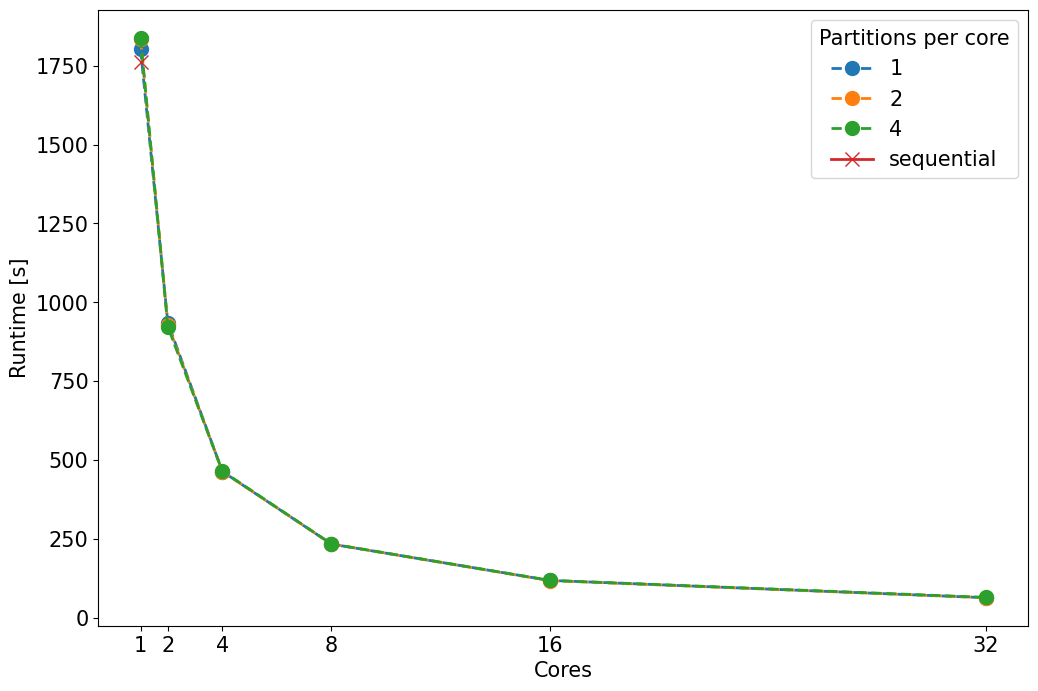

In [10]:
pyplot.rc('font', size=15)
fig, ax = pyplot.subplots(figsize=(12,8))
pyplot.xticks([1, 2, 4, 8, 16, 32])
pyplot.xlabel("Cores")
pyplot.ylabel("Runtime [s]")
for label, data in df_agg.groupby("partitions_per_core"):
    ax.plot(data.cores, data.others, marker="o",
            label=f"{label}",linewidth=2,
            markersize=10,linestyle="--")
ax.plot(1, seq_time, marker="x",
        label="sequential",linewidth=2,markersize=10)
ax.legend(title="Partitions per core")

In [11]:
dfs_parts = {}
for label, group in df_agg.groupby("partitions_per_core"):
    dfs_parts[label] = group
dfs_parts

{1:     cores  partitions_per_core        first       others  others_std  \
 0       1                    1  1807.388192  1802.427074   13.962643   
 3       2                    1   923.761953   935.312612   10.868163   
 6       4                    1   472.439025   463.462019    3.530522   
 9       8                    1   236.002850   233.256517    1.125309   
 12     16                    1   121.520587   118.201779    0.693810   
 15     32                    1    70.793046    63.271662    0.537521   
 
     others_throughput_MB  others_throughput_MB_per_core  others_speedup  
 0              62.261857                      62.261857        1.000000  
 3             119.983902                      59.991951        1.927085  
 6             242.139489                      60.534872        3.889050  
 9             481.111774                      60.138972        7.727231  
 12            949.414281                      59.338393       15.248731  
 15           1773.660649         

# TGraph

Info in <TCanvas::Print>: png file dask_singlenode_runtime.png has been created


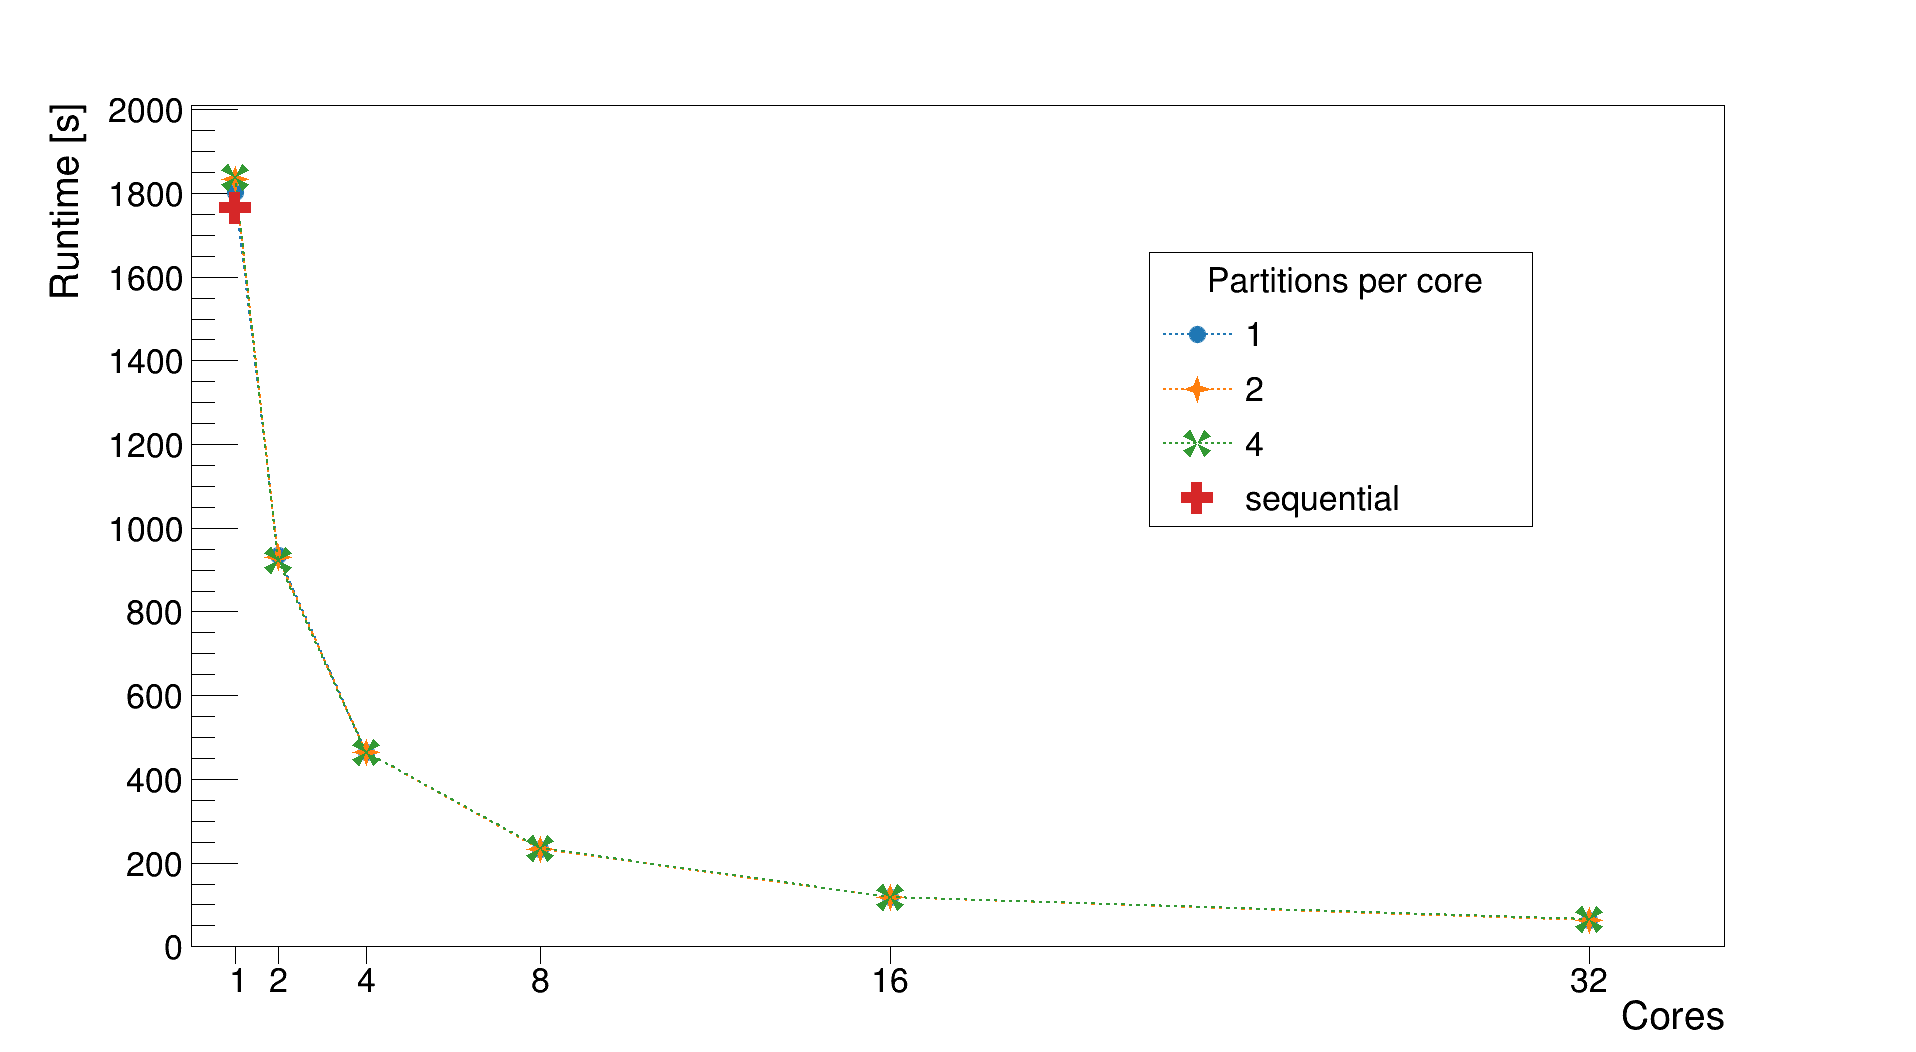

In [12]:
graph_1partspercore = ROOT.TGraph(len(dfs_parts[1]),
                                  numpy.array(dfs_parts[1]["cores"], dtype=float),
                                  numpy.array(dfs_parts[1]["others"], dtype=float))

graph_2partspercore = ROOT.TGraph(len(dfs_parts[2]),
                                  numpy.array(dfs_parts[2]["cores"], dtype=float),
                                  numpy.array(dfs_parts[2]["others"], dtype=float))

graph_4partspercore = ROOT.TGraph(len(dfs_parts[4]),
                                  numpy.array(dfs_parts[4]["cores"], dtype=float),
                                  numpy.array(dfs_parts[4]["others"], dtype=float))
graph_seq = ROOT.TGraph(1,
                        numpy.array([1], dtype=float),
                        numpy.array([seq_time], dtype=float))

width = 1920
height = 1080
c = ROOT.TCanvas("c", "", width, height)

ymin = graph_2partspercore.GetHistogram().GetMinimum()
ymax = graph_2partspercore.GetHistogram().GetMaximum()

graph_1partspercore.SetTitle("")

graph_1partspercore.GetXaxis().SetTitle("Cores")
graph_1partspercore.GetXaxis().SetTitleSize(0.04)
graph_1partspercore.GetXaxis().SetTitleOffset(1)
graph_1partspercore.GetXaxis().SetLabelSize(0)
graph_1partspercore.GetXaxis().SetTickLength(0)

graph_1partspercore.GetYaxis().SetTitle("Runtime [s]")
graph_1partspercore.GetYaxis().SetTitleSize(0.04)
graph_1partspercore.GetYaxis().SetTitleOffset(1)
graph_1partspercore.GetYaxis().SetRangeUser(0, ymax)
graph_1partspercore.GetYaxis().SetLabelSize(0.035)
#sparkgraph.GetYaxis().SetTickLength(0)


graph_1partspercore.SetMarkerColor(PYPLOT_TCOLORS["tab:blue"])
graph_1partspercore.SetMarkerSize(2)
graph_1partspercore.SetMarkerStyle(20)
graph_1partspercore.SetLineStyle(ROOT.kDashed)
graph_1partspercore.SetLineColorAlpha(PYPLOT_TCOLORS["tab:blue"],1)
graph_1partspercore.SetLineWidth(2)
graph_1partspercore.Draw("ALP")

dy = ymax - ymin
xlabels = []
xticks = []
#ylabels = []
#yticks = []

for i in range(len(dfs_parts[1])):
    x = graph_1partspercore.GetPointX(i)
    y = graph_1partspercore.GetPointY(i)

    xt = ROOT.TLatex(x, -110, str(int(x)))
    xt.SetTextSize(0.035)
    xt.SetTextFont(42)
    xt.SetTextAlign(21)
    xt.Draw()
    xlabels.append(xt)

    xl = ROOT.TLine(x, 0, x,0-0.02*dy)
    xl.Draw()
    xticks.append(xl)
    
    #yt = ROOT.TLatex(-0.5, y-0.2, str(int(y)))
    #yt.SetTextSize(0.03)
    #yt.SetTextFont(42)
    #yt.SetTextAlign(21)
    #yt.Draw()
    #ylabels.append(yt)

    #yl = ROOT.TLine(0, y, 0.3, y)
    #yl.Draw()
    #yticks.append(yl)

graph_2partspercore.GetYaxis().SetLabelSize(0)
graph_2partspercore.SetMarkerStyle(43)
graph_2partspercore.SetMarkerSize(3.5)
graph_2partspercore.SetMarkerColor(PYPLOT_TCOLORS["tab:orange"])
graph_2partspercore.SetLineStyle(ROOT.kDashed)
graph_2partspercore.SetLineColorAlpha(PYPLOT_TCOLORS["tab:orange"],1)
graph_2partspercore.SetLineWidth(2)
graph_2partspercore.Draw("SAME PL")

graph_4partspercore.GetYaxis().SetLabelSize(0)
graph_4partspercore.SetMarkerStyle(41)
graph_4partspercore.SetMarkerSize(3.5)
graph_4partspercore.SetMarkerColor(PYPLOT_TCOLORS["tab:green"])
graph_4partspercore.SetLineStyle(ROOT.kDashed)
graph_4partspercore.SetLineColorAlpha(PYPLOT_TCOLORS["tab:green"],1)
graph_4partspercore.SetLineWidth(2)
graph_4partspercore.Draw("SAME PL")

graph_seq.GetYaxis().SetLabelSize(0)
graph_seq.SetMarkerStyle(34)
graph_seq.SetMarkerSize(4)
graph_seq.SetMarkerColor(PYPLOT_TCOLORS["tab:red"])
graph_seq.Draw("SAME P")


legend = ROOT.TLegend(0.6,0.5,0.8,0.76)
legend.SetHeader("Partitions per core", "C")
legend.AddEntry(graph_1partspercore, "1")
legend.AddEntry(graph_2partspercore, "2")
legend.AddEntry(graph_4partspercore, "4")
legend.AddEntry(graph_seq, "sequential", "P")
legend.Draw()

ROOT.gStyle.SetLegendTextSize(0.035)

c.Draw()
c.SaveAs("dask_singlenode_runtime.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file dask_singlenode_runtime.png has been created


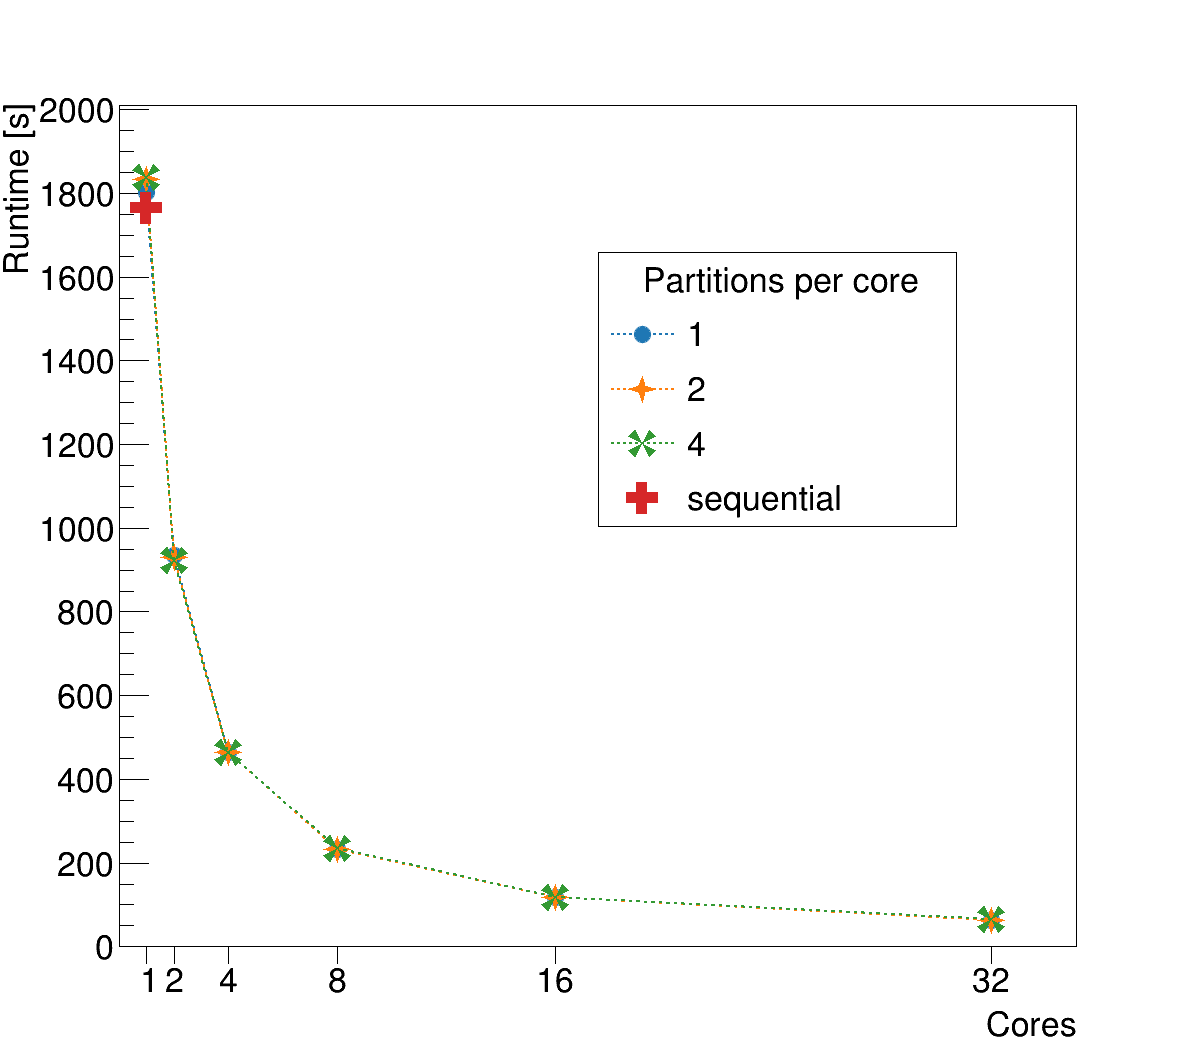

In [13]:
graph_1partspercore = ROOT.TGraph(len(dfs_parts[1]),
                                  numpy.array(dfs_parts[1]["cores"], dtype=float),
                                  numpy.array(dfs_parts[1]["others"], dtype=float))

graph_2partspercore = ROOT.TGraph(len(dfs_parts[2]),
                                  numpy.array(dfs_parts[2]["cores"], dtype=float),
                                  numpy.array(dfs_parts[2]["others"], dtype=float))

graph_4partspercore = ROOT.TGraph(len(dfs_parts[4]),
                                  numpy.array(dfs_parts[4]["cores"], dtype=float),
                                  numpy.array(dfs_parts[4]["others"], dtype=float))
graph_seq = ROOT.TGraph(1,
                        numpy.array([1], dtype=float),
                        numpy.array([seq_time], dtype=float))

width = 1200
height = 1080
c = ROOT.TCanvas("c", "", width, height)

ymin = graph_2partspercore.GetHistogram().GetMinimum()
ymax = graph_2partspercore.GetHistogram().GetMaximum()

graph_1partspercore.SetTitle("")

graph_1partspercore.GetXaxis().SetTitle("Cores")
graph_1partspercore.GetXaxis().SetTitleSize(0.035)
graph_1partspercore.GetXaxis().SetTitleOffset(1.3)
graph_1partspercore.GetXaxis().SetLabelSize(0)
graph_1partspercore.GetXaxis().SetTickLength(0)

graph_1partspercore.GetYaxis().SetTitle("Runtime [s]")
graph_1partspercore.GetYaxis().SetTitleSize(0.035)
graph_1partspercore.GetYaxis().SetTitleOffset(1.5)
graph_1partspercore.GetYaxis().SetRangeUser(0, ymax)
graph_1partspercore.GetYaxis().SetLabelSize(0.035)
#sparkgraph.GetYaxis().SetTickLength(0)


graph_1partspercore.SetMarkerColor(PYPLOT_TCOLORS["tab:blue"])
graph_1partspercore.SetMarkerSize(2)
graph_1partspercore.SetMarkerStyle(20)
graph_1partspercore.SetLineStyle(ROOT.kDashed)
graph_1partspercore.SetLineColorAlpha(PYPLOT_TCOLORS["tab:blue"],1)
graph_1partspercore.SetLineWidth(2)
graph_1partspercore.Draw("ALP")

dy = ymax - ymin
xlabels = []
xticks = []
#ylabels = []
#yticks = []

for i in range(len(dfs_parts[1])):
    x = graph_1partspercore.GetPointX(i)
    y = graph_1partspercore.GetPointY(i)

    xt = ROOT.TLatex(x, -110, str(int(x)))
    xt.SetTextSize(0.035)
    xt.SetTextFont(42)
    xt.SetTextAlign(21)
    xt.Draw()
    xlabels.append(xt)

    xl = ROOT.TLine(x, 0, x,0-0.02*dy)
    xl.Draw()
    xticks.append(xl)
    
    #yt = ROOT.TLatex(-0.5, y-0.2, str(int(y)))
    #yt.SetTextSize(0.03)
    #yt.SetTextFont(42)
    #yt.SetTextAlign(21)
    #yt.Draw()
    #ylabels.append(yt)

    #yl = ROOT.TLine(0, y, 0.3, y)
    #yl.Draw()
    #yticks.append(yl)

graph_2partspercore.GetYaxis().SetLabelSize(0)
graph_2partspercore.SetMarkerStyle(43)
graph_2partspercore.SetMarkerSize(3.5)
graph_2partspercore.SetMarkerColor(PYPLOT_TCOLORS["tab:orange"])
graph_2partspercore.SetLineStyle(ROOT.kDashed)
graph_2partspercore.SetLineColorAlpha(PYPLOT_TCOLORS["tab:orange"],1)
graph_2partspercore.SetLineWidth(2)
graph_2partspercore.Draw("SAME PL")

graph_4partspercore.GetYaxis().SetLabelSize(0)
graph_4partspercore.SetMarkerStyle(41)
graph_4partspercore.SetMarkerSize(3.5)
graph_4partspercore.SetMarkerColor(PYPLOT_TCOLORS["tab:green"])
graph_4partspercore.SetLineStyle(ROOT.kDashed)
graph_4partspercore.SetLineColorAlpha(PYPLOT_TCOLORS["tab:green"],1)
graph_4partspercore.SetLineWidth(2)
graph_4partspercore.Draw("SAME PL")

graph_seq.GetYaxis().SetLabelSize(0)
graph_seq.SetMarkerStyle(34)
graph_seq.SetMarkerSize(4)
graph_seq.SetMarkerColor(PYPLOT_TCOLORS["tab:red"])
graph_seq.Draw("SAME P")


legend = ROOT.TLegend(0.5,0.5,0.8,0.76)
legend.SetHeader("Partitions per core", "C")
legend.AddEntry(graph_1partspercore, "1")
legend.AddEntry(graph_2partspercore, "2")
legend.AddEntry(graph_4partspercore, "4")
legend.AddEntry(graph_seq, "sequential", "P")
legend.Draw()

ROOT.gStyle.SetLegendTextSize(0.035)

c.Draw()
c.SaveAs("dask_singlenode_runtime.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file dask_singlenode_throughput_per_core.png has been created


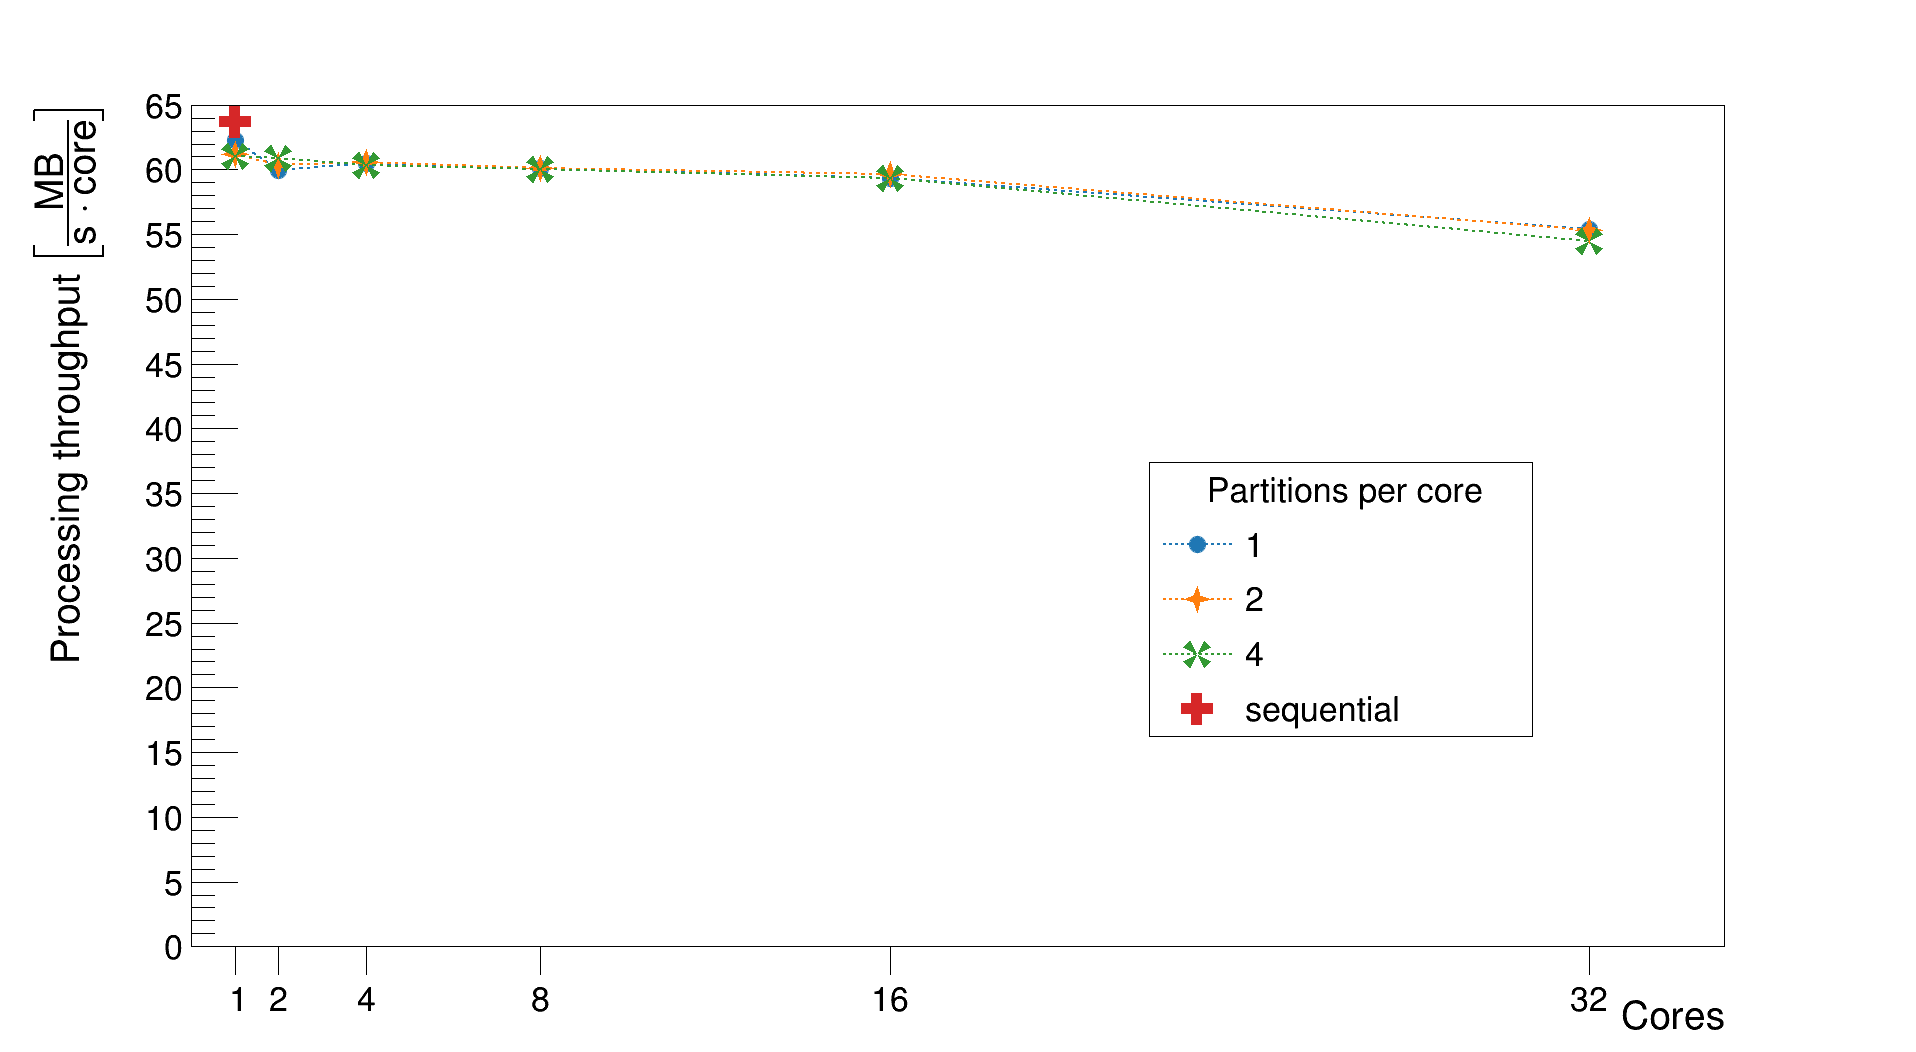

In [14]:
graph_1partspercore = ROOT.TGraph(len(dfs_parts[1]),
                                  numpy.array(dfs_parts[1]["cores"], dtype=float),
                                  numpy.array(dfs_parts[1]["others_throughput_MB_per_core"], dtype=float))

graph_2partspercore = ROOT.TGraph(len(dfs_parts[2]),
                                  numpy.array(dfs_parts[2]["cores"], dtype=float),
                                  numpy.array(dfs_parts[2]["others_throughput_MB_per_core"], dtype=float))

graph_4partspercore = ROOT.TGraph(len(dfs_parts[4]),
                                  numpy.array(dfs_parts[4]["cores"], dtype=float),
                                  numpy.array(dfs_parts[4]["others_throughput_MB_per_core"], dtype=float))

graph_seq = ROOT.TGraph(1,
                        numpy.array([1], dtype=float),
                        numpy.array([seq_throughput_MB], dtype=float))

width = 1920
height = 1080
c = ROOT.TCanvas("c", "", width, height)

ymin = graph_2partspercore.GetHistogram().GetMinimum()
ymax = graph_2partspercore.GetHistogram().GetMaximum()

graph_1partspercore.SetTitle("")

graph_1partspercore.GetXaxis().SetTitle("Cores")
graph_1partspercore.GetXaxis().SetTitleSize(0.04)
graph_1partspercore.GetXaxis().SetTitleOffset(1)
graph_1partspercore.GetXaxis().SetLabelSize(0)
graph_1partspercore.GetXaxis().SetTickLength(0)

graph_1partspercore.GetYaxis().SetTitle("Processing throughput #left[#frac{MB}{s #upoint core}#right]")
graph_1partspercore.GetYaxis().SetTitleSize(0.04)
graph_1partspercore.GetYaxis().SetTitleOffset(1)
graph_1partspercore.GetYaxis().SetRangeUser(0, 65)
graph_1partspercore.GetYaxis().SetLabelSize(0.035)
graph_1partspercore.GetYaxis().SetNdivisions(13, 5, 0)

graph_1partspercore.SetMarkerColor(PYPLOT_TCOLORS["tab:blue"])
graph_1partspercore.SetMarkerSize(2)
graph_1partspercore.SetMarkerStyle(20)
graph_1partspercore.SetLineStyle(ROOT.kDashed)
graph_1partspercore.SetLineColorAlpha(PYPLOT_TCOLORS["tab:blue"],1)
graph_1partspercore.SetLineWidth(2)
graph_1partspercore.Draw("ALP")

dy = ymax - ymin
xlabels = []
xticks = []
#ylabels = []
#yticks = []

for i in range(len(dfs_parts[1])):
    x = graph_1partspercore.GetPointX(i)
    y = graph_1partspercore.GetPointY(i)

    xt = ROOT.TLatex(x, -5, str(int(x)))
    xt.SetTextSize(0.035)
    xt.SetTextFont(42)
    xt.SetTextAlign(21)
    xt.Draw()
    xlabels.append(xt)

    xl = ROOT.TLine(x, 0, x,0-0.3*dy)
    xl.Draw()
    xticks.append(xl)
    
    #yt = ROOT.TLatex(-0.5, y-0.2, str(int(y)))
    #yt.SetTextSize(0.03)
    #yt.SetTextFont(42)
    #yt.SetTextAlign(21)
    #yt.Draw()
    #ylabels.append(yt)

    #yl = ROOT.TLine(0, y, 0.3, y)
    #yl.Draw()
    #yticks.append(yl)

graph_2partspercore.GetYaxis().SetLabelSize(0)
graph_2partspercore.SetMarkerStyle(43)
graph_2partspercore.SetMarkerSize(3.5)
graph_2partspercore.SetMarkerColor(PYPLOT_TCOLORS["tab:orange"])
graph_2partspercore.SetLineStyle(ROOT.kDashed)
graph_2partspercore.SetLineColorAlpha(PYPLOT_TCOLORS["tab:orange"],1)
graph_2partspercore.SetLineWidth(2)
graph_2partspercore.Draw("SAME PL")

graph_4partspercore.GetYaxis().SetLabelSize(0)
graph_4partspercore.SetMarkerStyle(41)
graph_4partspercore.SetMarkerSize(3.5)
graph_4partspercore.SetMarkerColor(PYPLOT_TCOLORS["tab:green"])
graph_4partspercore.SetLineStyle(ROOT.kDashed)
graph_4partspercore.SetLineColorAlpha(PYPLOT_TCOLORS["tab:green"],1)
graph_4partspercore.SetLineWidth(2)
graph_4partspercore.Draw("SAME PL")

graph_seq.GetYaxis().SetLabelSize(0)
graph_seq.SetMarkerStyle(34)
graph_seq.SetMarkerSize(4)
graph_seq.SetMarkerColor(PYPLOT_TCOLORS["tab:red"])
graph_seq.Draw("SAME P")

legend = ROOT.TLegend(0.6,0.3,0.8,0.56)
legend.SetHeader("Partitions per core", "C")
legend.AddEntry(graph_1partspercore, "1")
legend.AddEntry(graph_2partspercore, "2")
legend.AddEntry(graph_4partspercore, "4")
legend.AddEntry(graph_seq, "sequential", "P")
legend.Draw()

ROOT.gStyle.SetLegendTextSize(0.035)

c.Draw()
c.SaveAs("dask_singlenode_throughput_per_core.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file dask_singlenode_throughput_per_core.png has been created


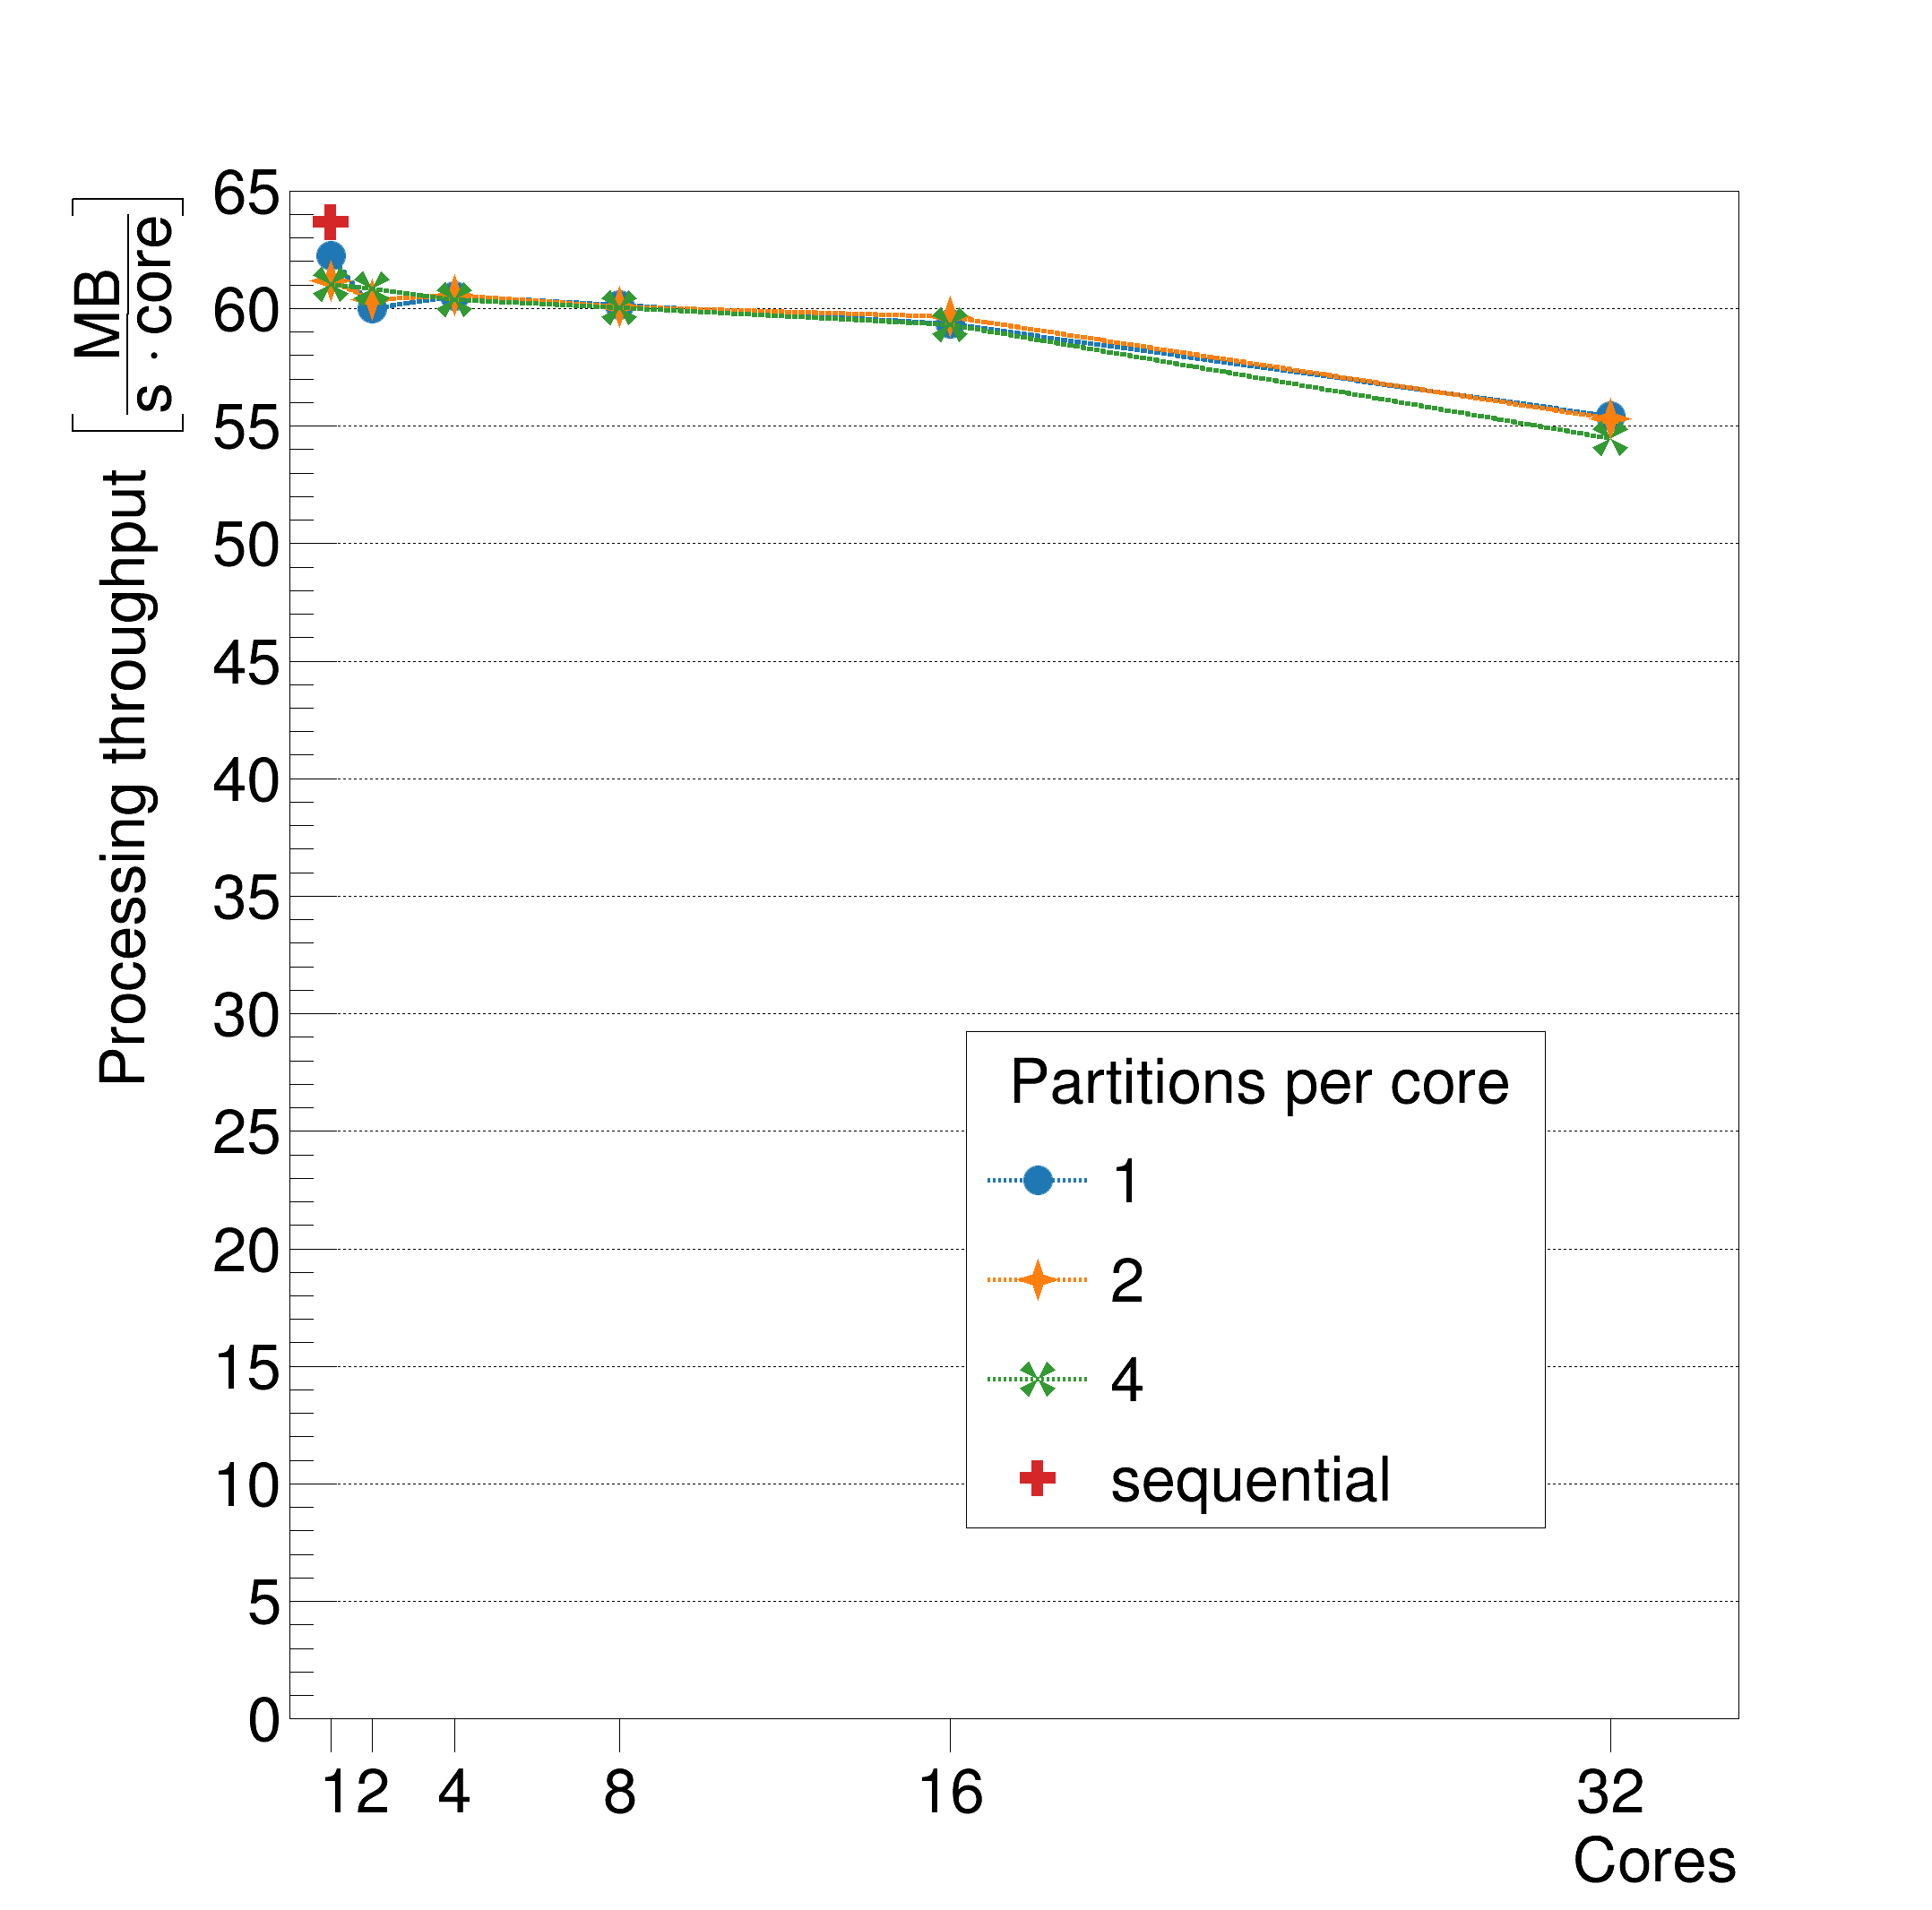

In [15]:
graph_1partspercore = ROOT.TGraph(len(dfs_parts[1]),
                                  numpy.array(dfs_parts[1]["cores"], dtype=float),
                                  numpy.array(dfs_parts[1]["others_throughput_MB_per_core"], dtype=float))

graph_2partspercore = ROOT.TGraph(len(dfs_parts[2]),
                                  numpy.array(dfs_parts[2]["cores"], dtype=float),
                                  numpy.array(dfs_parts[2]["others_throughput_MB_per_core"], dtype=float))

graph_4partspercore = ROOT.TGraph(len(dfs_parts[4]),
                                  numpy.array(dfs_parts[4]["cores"], dtype=float),
                                  numpy.array(dfs_parts[4]["others_throughput_MB_per_core"], dtype=float))

graph_seq = ROOT.TGraph(1,
                        numpy.array([1], dtype=float),
                        numpy.array([seq_throughput_MB], dtype=float))

width = 2160
height = 2160
c = ROOT.TCanvas("c", "", width, height)
c.SetLeftMargin(0.15)

ymin = graph_2partspercore.GetHistogram().GetMinimum()
ymax = graph_2partspercore.GetHistogram().GetMaximum()

graph_1partspercore.SetTitle("")

graph_1partspercore.GetXaxis().SetTitle("Cores")
graph_1partspercore.GetXaxis().SetTitleSize(0.035)
graph_1partspercore.GetXaxis().SetTitleOffset(1.3)
graph_1partspercore.GetXaxis().SetLabelSize(0)
graph_1partspercore.GetXaxis().SetTickLength(0)

graph_1partspercore.GetYaxis().SetTitle("Processing throughput #left[#frac{MB}{s #upoint core}#right]")
graph_1partspercore.GetYaxis().SetTitleSize(0.035)
graph_1partspercore.GetYaxis().SetTitleOffset(1.5)
graph_1partspercore.GetYaxis().SetRangeUser(0, 65)
graph_1partspercore.GetYaxis().SetLabelSize(0.035)
graph_1partspercore.GetYaxis().SetNdivisions(13, 5, 0)

graph_1partspercore.SetMarkerColor(PYPLOT_TCOLORS["tab:blue"])
graph_1partspercore.SetMarkerSize(4)
graph_1partspercore.SetMarkerStyle(20)
graph_1partspercore.SetLineStyle(ROOT.kDashed)
graph_1partspercore.SetLineColorAlpha(PYPLOT_TCOLORS["tab:blue"],1)
graph_1partspercore.SetLineWidth(5)
graph_1partspercore.Draw("ALP")

dy = ymax - ymin
xlabels = []
xticks = []
#ylabels = []
#yticks = []

for i in range(len(dfs_parts[1])):
    x = graph_1partspercore.GetPointX(i)
    y = graph_1partspercore.GetPointY(i)

    xt = ROOT.TLatex(x, -4, str(int(x)))
    xt.SetTextSize(0.035)
    xt.SetTextFont(42)
    xt.SetTextAlign(21)
    xt.Draw()
    xlabels.append(xt)

    xl = ROOT.TLine(x, 0, x,0-0.2*dy)
    xl.Draw()
    xticks.append(xl)
    
    #yt = ROOT.TLatex(-0.5, y-0.2, str(int(y)))
    #yt.SetTextSize(0.03)
    #yt.SetTextFont(42)
    #yt.SetTextAlign(21)
    #yt.Draw()
    #ylabels.append(yt)

    #yl = ROOT.TLine(0, y, 0.3, y)
    #yl.Draw()
    #yticks.append(yl)

graph_2partspercore.GetYaxis().SetLabelSize(0)
graph_2partspercore.SetMarkerStyle(43)
graph_2partspercore.SetMarkerSize(6)
graph_2partspercore.SetMarkerColor(PYPLOT_TCOLORS["tab:orange"])
graph_2partspercore.SetLineStyle(ROOT.kDashed)
graph_2partspercore.SetLineColorAlpha(PYPLOT_TCOLORS["tab:orange"],1)
graph_2partspercore.SetLineWidth(5)
graph_2partspercore.Draw("SAME PL")

graph_4partspercore.GetYaxis().SetLabelSize(0)
graph_4partspercore.SetMarkerStyle(41)
graph_4partspercore.SetMarkerSize(5)
graph_4partspercore.SetMarkerColor(PYPLOT_TCOLORS["tab:green"])
graph_4partspercore.SetLineStyle(ROOT.kDashed)
graph_4partspercore.SetLineColorAlpha(PYPLOT_TCOLORS["tab:green"],1)
graph_4partspercore.SetLineWidth(5)
graph_4partspercore.Draw("SAME PL")

graph_seq.GetYaxis().SetLabelSize(0)
graph_seq.SetMarkerStyle(34)
graph_seq.SetMarkerSize(5)
graph_seq.SetMarkerColor(PYPLOT_TCOLORS["tab:red"])
graph_seq.Draw("SAME P")

legend = ROOT.TLegend(0.5,0.2,0.8,0.46)
legend.SetHeader("Partitions per core", "C")
legend.AddEntry(graph_1partspercore, "1")
legend.AddEntry(graph_2partspercore, "2")
legend.AddEntry(graph_4partspercore, "4")
legend.AddEntry(graph_seq, "sequential", "P")
legend.Draw()

ROOT.gStyle.SetLegendTextSize(0.035)
ROOT.gStyle.SetGridWidth(1)
ROOT.gStyle.SetGridStyle(2)

c.SetGridy()

c.Draw()
c.SaveAs("dask_singlenode_throughput_per_core.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file dask_singlenode_throughput.png has been created


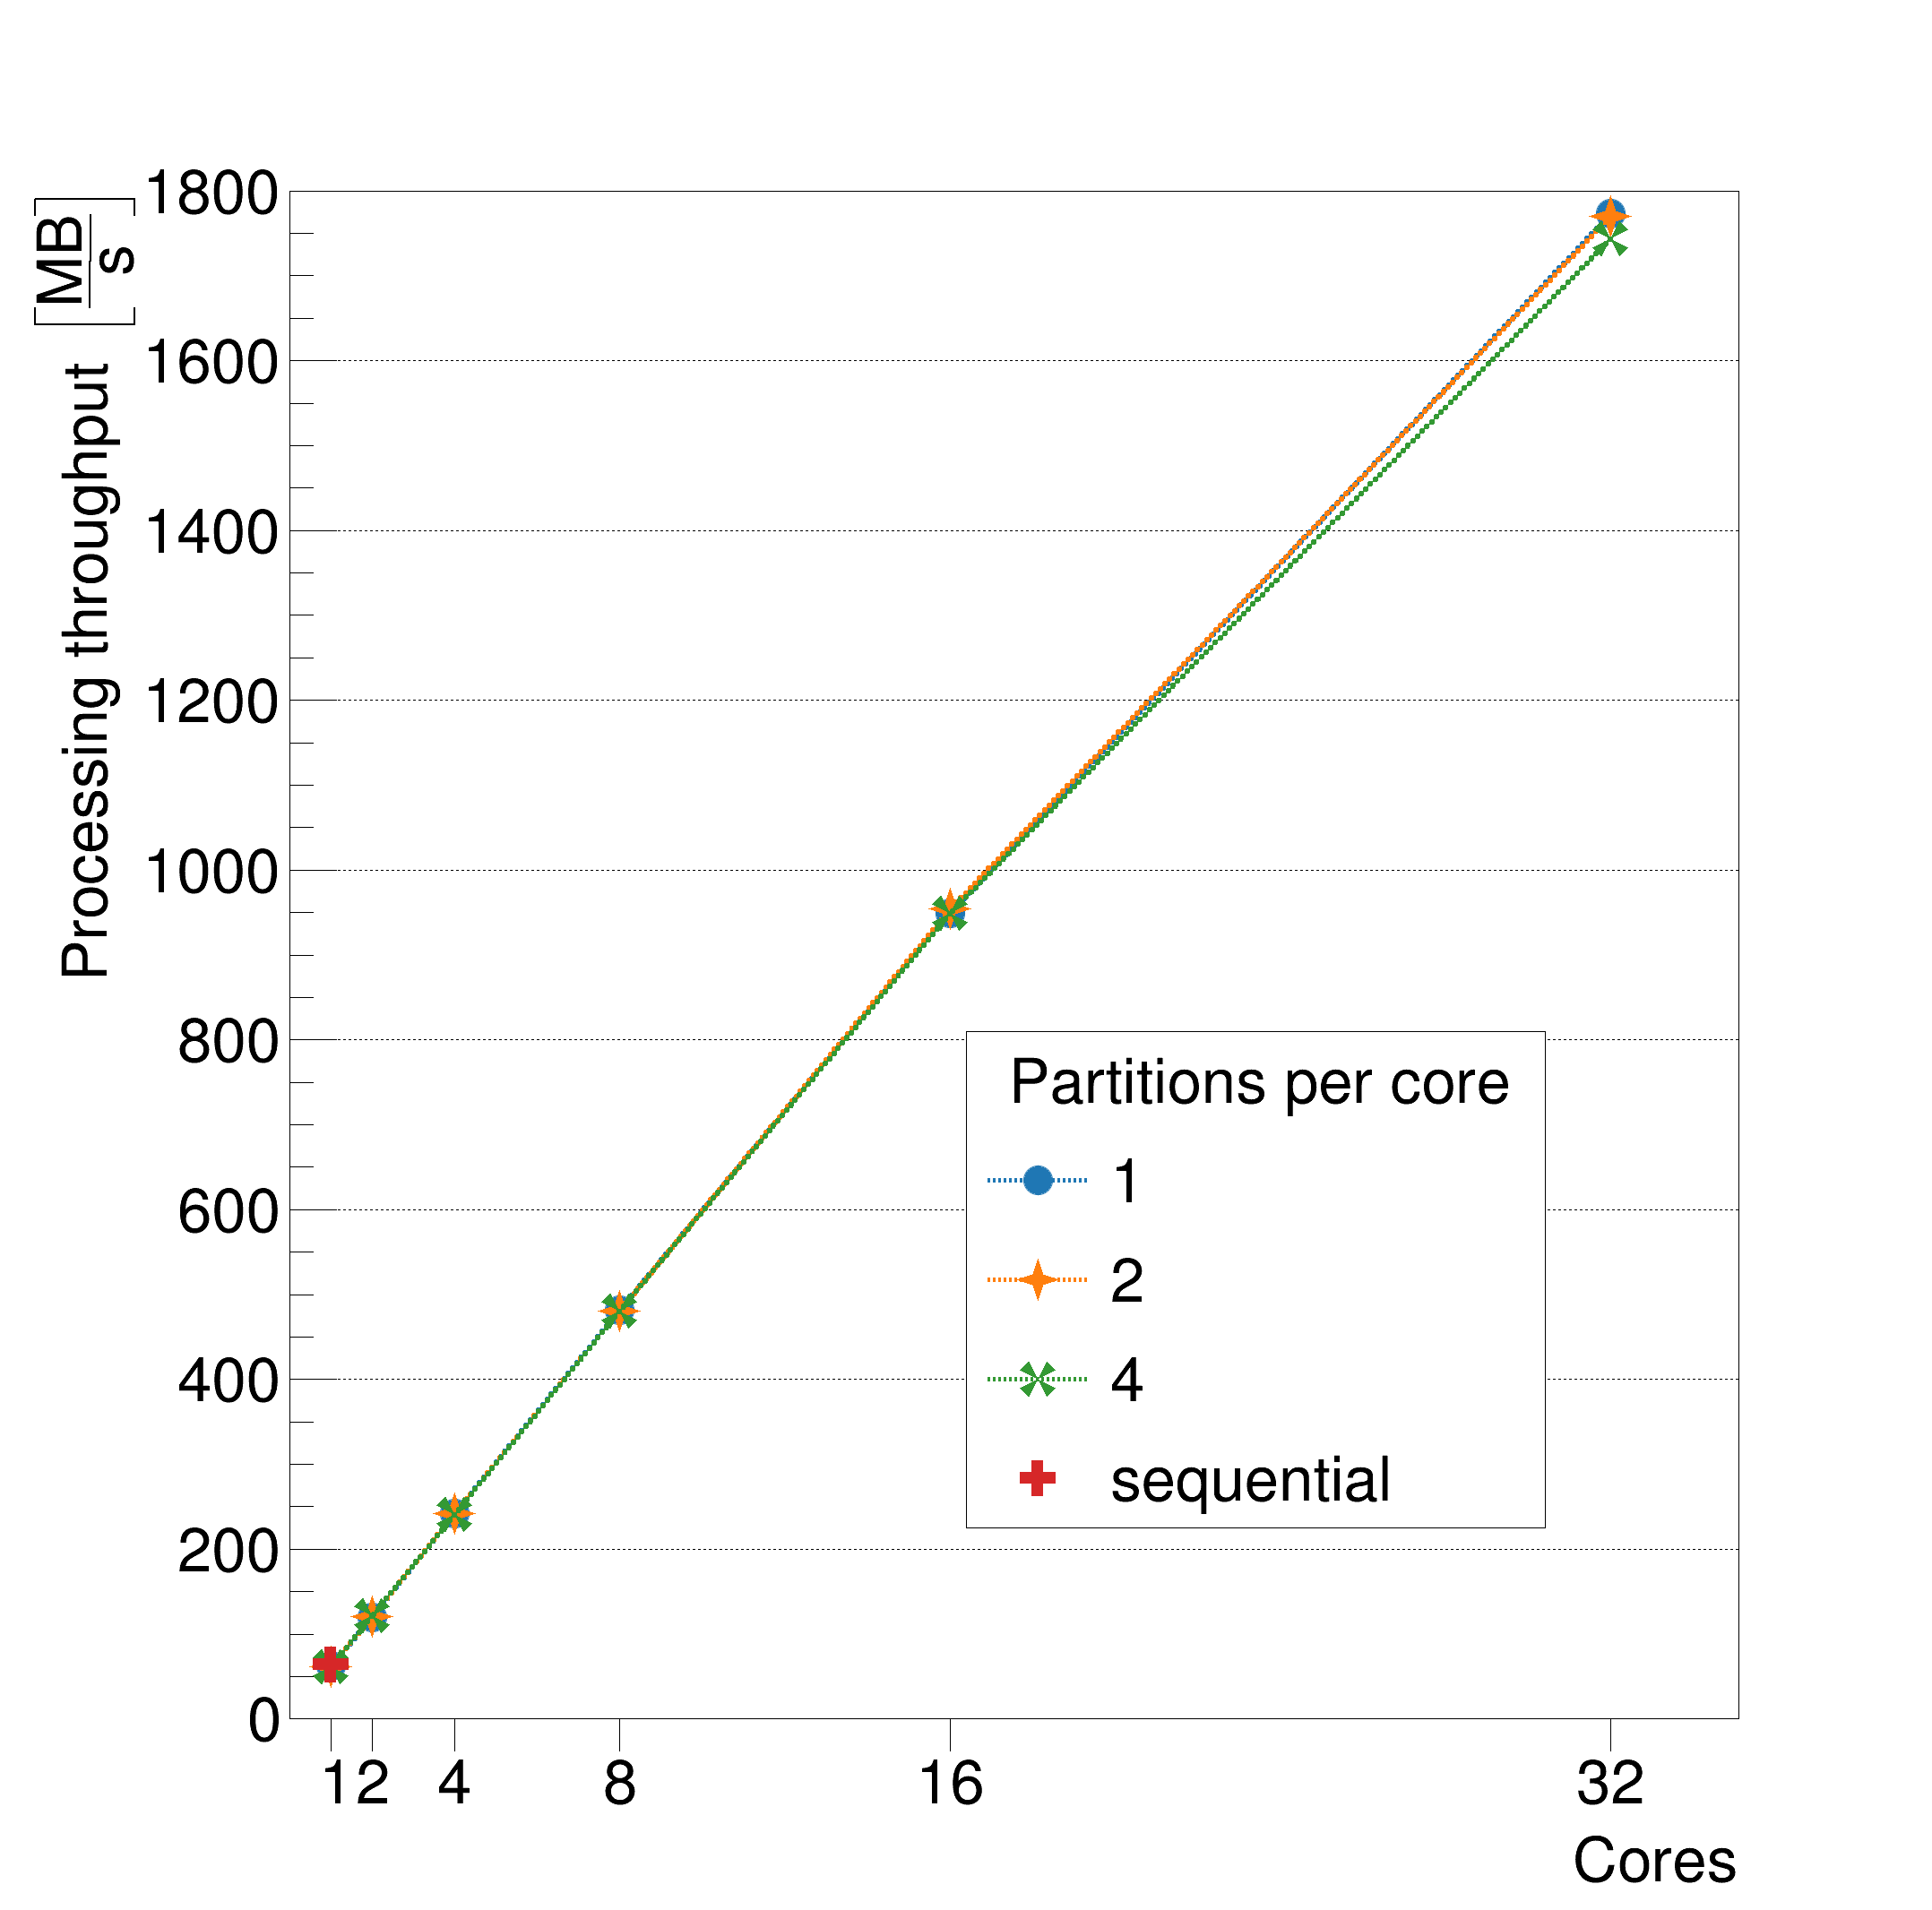

In [16]:
graph_1partspercore = ROOT.TGraph(len(dfs_parts[1]),
                                  numpy.array(dfs_parts[1]["cores"], dtype=float),
                                  numpy.array(dfs_parts[1]["others_throughput_MB"], dtype=float))

graph_2partspercore = ROOT.TGraph(len(dfs_parts[2]),
                                  numpy.array(dfs_parts[2]["cores"], dtype=float),
                                  numpy.array(dfs_parts[2]["others_throughput_MB"], dtype=float))

graph_4partspercore = ROOT.TGraph(len(dfs_parts[4]),
                                  numpy.array(dfs_parts[4]["cores"], dtype=float),
                                  numpy.array(dfs_parts[4]["others_throughput_MB"], dtype=float))

graph_seq = ROOT.TGraph(1,
                        numpy.array([1], dtype=float),
                        numpy.array([seq_throughput_MB], dtype=float))

width = 2160
height = 2160
c = ROOT.TCanvas("c", "", width, height)
c.SetLeftMargin(0.15)

ymin = graph_2partspercore.GetHistogram().GetMinimum()
ymax = graph_2partspercore.GetHistogram().GetMaximum()

graph_1partspercore.SetTitle("")

graph_1partspercore.GetXaxis().SetTitle("Cores")
graph_1partspercore.GetXaxis().SetTitleSize(0.035)
graph_1partspercore.GetXaxis().SetTitleOffset(1.3)
graph_1partspercore.GetXaxis().SetLabelSize(0)
graph_1partspercore.GetXaxis().SetTickLength(0)

graph_1partspercore.GetYaxis().SetTitle("Processing throughput #left[#frac{MB}{s}#right]")
graph_1partspercore.GetYaxis().SetTitleSize(0.035)
graph_1partspercore.GetYaxis().SetTitleOffset(1.9)
graph_1partspercore.GetYaxis().SetLabelSize(0.035)
graph_1partspercore.GetYaxis().SetRangeUser(0, 1800)

graph_1partspercore.SetMarkerColor(PYPLOT_TCOLORS["tab:blue"])
graph_1partspercore.SetMarkerSize(4)
graph_1partspercore.SetMarkerStyle(20)
graph_1partspercore.SetLineStyle(ROOT.kDashed)
graph_1partspercore.SetLineColorAlpha(PYPLOT_TCOLORS["tab:blue"],1)
graph_1partspercore.SetLineWidth(5)
graph_1partspercore.Draw("ALP")

dy = ymax - ymin
xlabels = []
xticks = []
#ylabels = []
#yticks = []

for i in range(len(dfs_parts[1])):
    x = graph_1partspercore.GetPointX(i)
    y = graph_1partspercore.GetPointY(i)

    xt = ROOT.TLatex(x, -100, str(int(x)))
    xt.SetTextSize(0.035)
    xt.SetTextFont(42)
    xt.SetTextAlign(21)
    xt.Draw()
    xlabels.append(xt)

    xl = ROOT.TLine(x, 0, x,0-0.02*dy)
    xl.Draw()
    xticks.append(xl)

    #yt = ROOT.TLatex(-0.5, y-0.2, str(int(y)))
    #yt.SetTextSize(0.03)
    #yt.SetTextFont(42)
    #yt.SetTextAlign(21)
    #yt.Draw()
    #ylabels.append(yt)

    #yl = ROOT.TLine(0, y, 0.3, y)
    #yl.Draw()
    #yticks.append(yl)

graph_2partspercore.GetYaxis().SetLabelSize(0)
graph_2partspercore.SetMarkerStyle(43)
graph_2partspercore.SetMarkerSize(6)
graph_2partspercore.SetMarkerColor(PYPLOT_TCOLORS["tab:orange"])
graph_2partspercore.SetLineStyle(ROOT.kDashed)
graph_2partspercore.SetLineColorAlpha(PYPLOT_TCOLORS["tab:orange"],1)
graph_2partspercore.SetLineWidth(5)
graph_2partspercore.Draw("SAME PL")

graph_4partspercore.GetYaxis().SetLabelSize(0)
graph_4partspercore.SetMarkerStyle(41)
graph_4partspercore.SetMarkerSize(5)
graph_4partspercore.SetMarkerColor(PYPLOT_TCOLORS["tab:green"])
graph_4partspercore.SetLineStyle(ROOT.kDashed)
graph_4partspercore.SetLineColorAlpha(PYPLOT_TCOLORS["tab:green"],1)
graph_4partspercore.SetLineWidth(5)
graph_4partspercore.Draw("SAME PL")

graph_seq.GetYaxis().SetLabelSize(0)
graph_seq.SetMarkerStyle(34)
graph_seq.SetMarkerSize(5)
graph_seq.SetMarkerColor(PYPLOT_TCOLORS["tab:red"])
graph_seq.Draw("SAME P")

legend = ROOT.TLegend(0.5,0.2,0.8,0.46)
legend.SetHeader("Partitions per core", "C")
legend.AddEntry(graph_1partspercore, "1")
legend.AddEntry(graph_2partspercore, "2")
legend.AddEntry(graph_4partspercore, "4")
legend.AddEntry(graph_seq, "sequential", "P")
legend.Draw()

ROOT.gStyle.SetLegendTextSize(0.035)
ROOT.gStyle.SetGridWidth(1)
ROOT.gStyle.SetGridStyle(2)

c.SetGridy()
c.Draw()
c.SaveAs("dask_singlenode_throughput.png")